#**CNN & APPLICATIONS**

##**CNN for Image Classification**

In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

AttributeError: module 'torch.library' has no attribute 'register_fake'

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

###**MNIST Dataset**

####**Load Dataset**

In [3]:
ROOT = './data'

train_data = datasets.MNIST(
    root=ROOT,
    train=True,
    download=True
)

test_data = datasets.MNIST(
    root=ROOT,
    train=False,
    download=True
    )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.16MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.87MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [6]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [8]:
train_data.targets.shape

torch.Size([60000])

In [9]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [10]:
# plot images
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='bone')
        ax.axis('off')

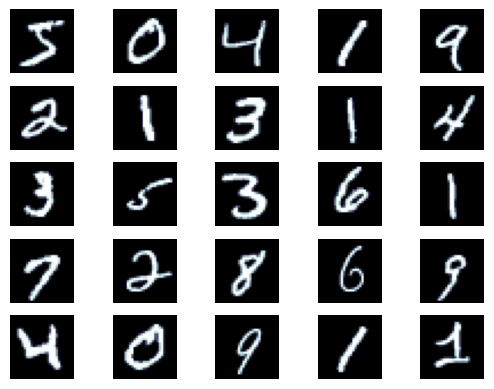

In [11]:
N_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images)

####**Preprocessing**

**Train: Valid = 0.9 : 0.1**

In [12]:
len(train_data)

60000

In [13]:
train_data, valid_data = torch.utils.data.random_split(train_data, [54000, 6000])
len(valid_data)

6000

**Preprocessing with `transforms`**

- Normalization (mean, sdt)
- Convert to tensor

In [14]:
# compute mean and std
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255
mean, std

(tensor(0.1307), tensor(0.3081))

In [15]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [16]:
train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

####**Dataloader**

In [17]:
BATCH_SIZE = 256

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)

In [18]:
len(train_dataloader)

211

In [23]:
sample = next(iter(train_dataloader))
sample[0].shape, sample[1].shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

####**Model**

http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

In [31]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
      super(LeNetClassifier, self).__init__()
      self.conv1 = nn.Conv2d(
          in_channels=1, out_channels=6, kernel_size=5, padding='same'
      )
      self.avgpool1 = nn.AvgPool2d(kernel_size=2)
      self.conv2 = nn.Conv2d(
          in_channels=6, out_channels=16, kernel_size=5
      )
      self.avgpool2 = nn.AvgPool2d(kernel_size=2)
      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
      self.fc2 = nn.Linear(in_features=120, out_features=84)
      self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, inputs):
      x = self.conv1(inputs)
      x = self.avgpool1(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = self.avgpool2(x)
      x = F.relu(x)
      x = self.flatten(x)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      x = F.relu(x)
      x = self.fc3(x)
      return x

In [32]:
num_classes = len(train_data.dataset.classes)
num_classes

10

In [33]:
lenet_model = LeNetClassifier(num_classes)

In [34]:
lenet_model

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [35]:
inputs, labels = next(iter(train_dataloader))
inputs.shape, labels.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [36]:
predictions = lenet_model(inputs)
predictions.shape

torch.Size([256, 10])

In [38]:
print('labels: ', labels[0])
print('pred: ', predictions[0])

labels:  tensor(0)
pred:  tensor([ 0.1237,  0.0423, -0.0862,  0.0731,  0.0628, -0.0543, -0.0663, -0.0125,
         0.0405, -0.0724], grad_fn=<SelectBackward0>)


####**Loss & Optimizer**

In [39]:
optimizer = optim.Adam(lenet_model.parameters())

In [40]:
criterion = nn.CrossEntropyLoss()

In [41]:
loss = criterion(predictions, labels)
loss

tensor(2.3028, grad_fn=<NllLossBackward0>)

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
lenet_model.to(device)

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

####**Trainer**

In [44]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [45]:
train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device)

| epoch   0 |    50/  211 batches | accuracy    0.615
| epoch   0 |   100/  211 batches | accuracy    0.873
| epoch   0 |   150/  211 batches | accuracy    0.904
| epoch   0 |   200/  211 batches | accuracy    0.927


In [46]:
train_acc, train_loss

(0.9292452830188679, 0.5596710510587241)

In [47]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [48]:
eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)

In [49]:
eval_acc, eval_loss

(0.9385, 0.21788583416491747)

####**Training**

In [55]:
num_classes = len(train_data.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

num_epochs = 50
save_model = './models'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        os.makedirs(save_model, exist_ok=True)
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.5f} | Train Loss {:8.5f} "
        "| Valid Accuracy {:8.5f} | Valid Loss {:8.5f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt', weights_only=True))
    lenet_model.eval()

| epoch   1 |    50/  211 batches | accuracy    0.586
| epoch   1 |   100/  211 batches | accuracy    0.865
| epoch   1 |   150/  211 batches | accuracy    0.905
| epoch   1 |   200/  211 batches | accuracy    0.926
-----------------------------------------------------------
| End of epoch   1 | Time: 13.36s | Train Accuracy    0.930 | Train Loss    0.577 | Valid Accuracy    0.933 | Valid Loss    0.226 
-----------------------------------------------------------
| epoch   2 |    50/  211 batches | accuracy    0.938
| epoch   2 |   100/  211 batches | accuracy    0.953
| epoch   2 |   150/  211 batches | accuracy    0.958
| epoch   2 |   200/  211 batches | accuracy    0.964
-----------------------------------------------------------
| End of epoch   2 | Time: 14.17s | Train Accuracy    0.963 | Train Loss    0.152 | Valid Accuracy    0.965 | Valid Loss    0.120 
-----------------------------------------------------------
| epoch   3 |    50/  211 batches | accuracy    0.968
| epoch   3 

In [56]:
eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
eval_acc, eval_loss

(0.9873333333333333, 0.08098524326245145)

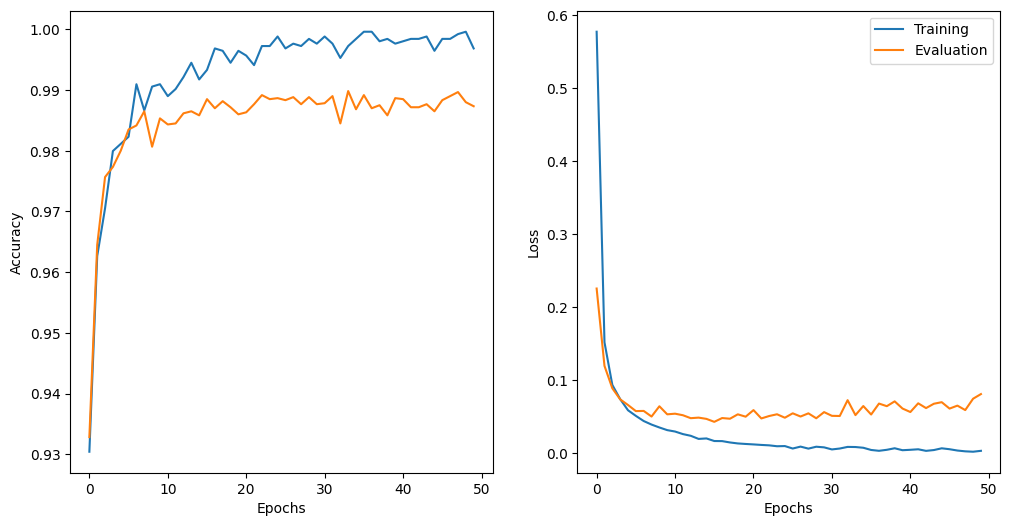

In [57]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

####**Evaluation & Prediction**

In [58]:
test_data.transform = test_transforms

In [59]:
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

In [60]:
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device)
test_acc, test_loss

(0.9871, 0.07279525877979828)

In [61]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

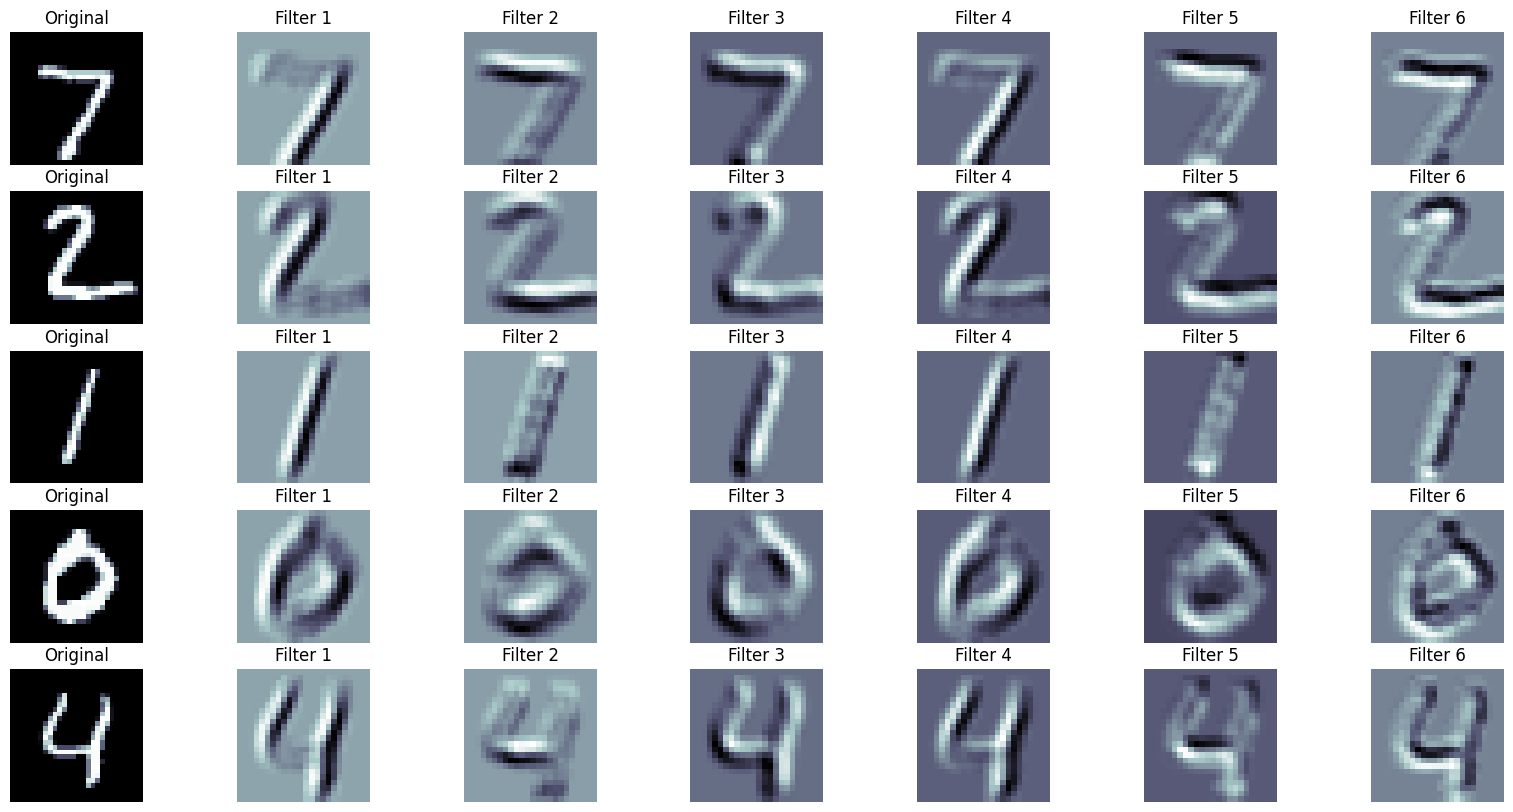

In [62]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = lenet_model.conv1.weight.data

plot_filtered_images(images, filters)

####**Inference**

In [63]:
def load_model(model_path, num_classes=10):
    lenet_model = LeNetClassifier(num_classes)
    lenet_model.load_state_dict(torch.load(model_path, weights_only=True))
    lenet_model.eval()
    return lenet_model

def inference(img_path, model):
    image = Image.open(img_path)
    w, h = image.size
    if w != h:
        crop = transforms.CenterCrop(min(w, h))
        image = crop(image)
        wnew, hnew = image.size
    img_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081])
    ])
    img_new = img_transform(image)
    img_new = img_new.expand(1, 1, 28, 28)
    with torch.no_grad():
        predictions = model(img_new)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return p_max.item(), yhat.item()

In [64]:
model = load_model('/content/models/lenet_model.pt')
preds = inference('/content/demo_8.png', model)
preds

(1.0, 8)

###**Cassava Leaf Disease**

####**Load Dataset**

**Download Dataset**

In [65]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip \
                -O /content/cassavaleafdata.zip

--2024-12-10 13:57:21--  https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1354096203 (1.3G) [application/octet-stream]
Saving to: ‘/content/cassavaleafdata.zip’

/content/cassavalea 100%[===================>]   1.26G  34.7MB/s    in 37s     

2024-12-10 13:57:58 (35.0 MB/s) - ‘/content/cassavaleafdata.zip’ saved [1354096203/1354096203]



In [ ]:
!unzip /content/cassavaleafdata.zip

**Read Dataset**

In [67]:
%cd /content/cassavaleafdata

/content/cassavaleafdata


In [68]:
data_paths = {
    'train': './train',
    'valid': './validation',
    'test': './test'
}

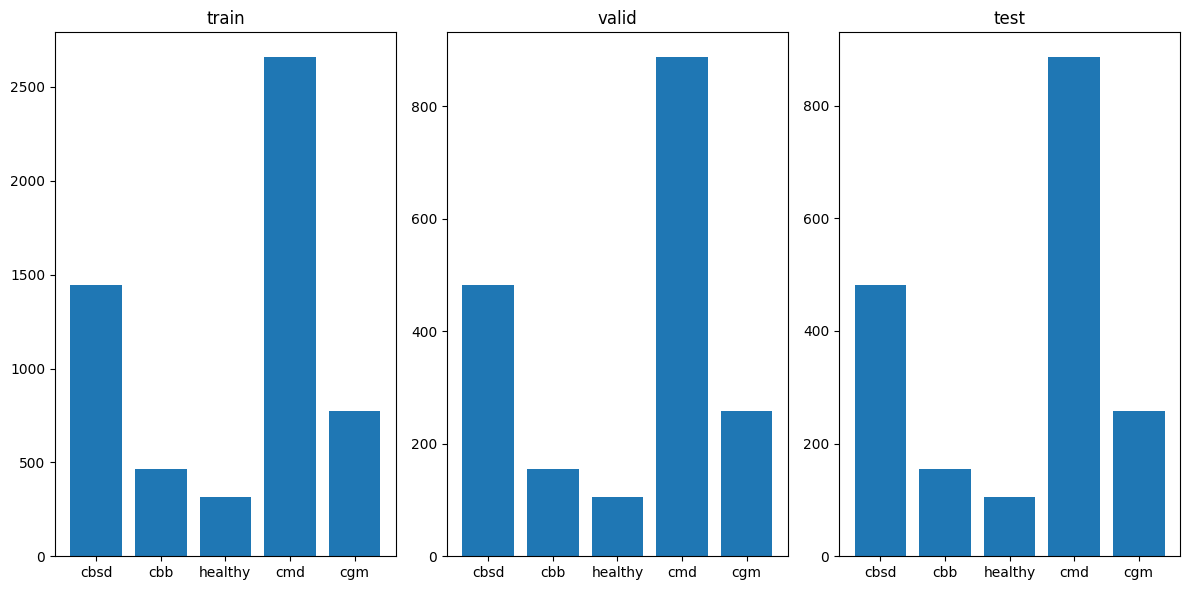

In [69]:
from imutils import paths
def show_labels(data_paths):
    fig, ax = plt.subplots(1, len(data_paths), figsize=(12,6))
    for idx, (key, sub_dir) in enumerate(data_paths.items()):
        labels = os.listdir(sub_dir)
        list_data = []
        for label in labels:
            image_files = list(paths.list_images(os.path.join(sub_dir, label)))
            list_data.append(len(image_files))
        ax[idx].bar(labels, list_data)
        ax[idx].set_title(key)
    plt.tight_layout()
    plt.show()

show_labels(data_paths)

In [70]:
labels_dict = {
    "cbb": "Cassava Bacterial Blight (CBB)",
    "cbsd": "Cassava Brown Streak Disease (CBSD)",
    "cgm": "Cassava Green Mottle (CGM)",
    "cmd": "Cassava Mosaic Disease (CMD)",
    "healthy": "Healthy"
}

In [71]:
def plot_images(data_dir, label, num_sample=6):
    data_dir = os.path.join(data_dir, label)
    image_files = list(paths.list_images(data_dir))[:num_sample]
    fig, ax = plt.subplots(2,num_sample//2, figsize=(14,7))
    for i, image_dir in enumerate(image_files):
        img = Image.open(image_dir)
        label = image_dir.split('/')[-2]
        ax[i//(num_sample//2)][i%(num_sample//2)].imshow(img)
        ax[i//(num_sample//2)][i%(num_sample//2)].set_title(labels_dict[label])
        ax[i//(num_sample//2)][i%(num_sample//2)].axis('off')
    plt.tight_layout()
    plt.show()

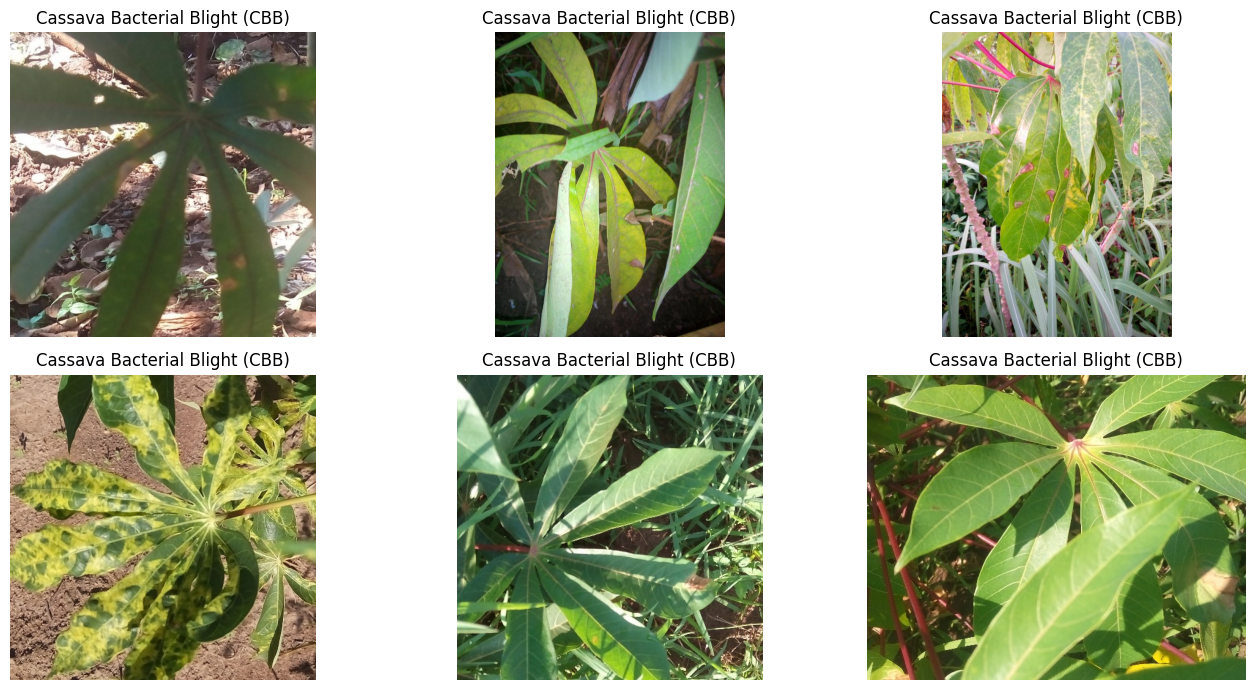

In [72]:
plot_images(data_paths['train'], label="cbb")

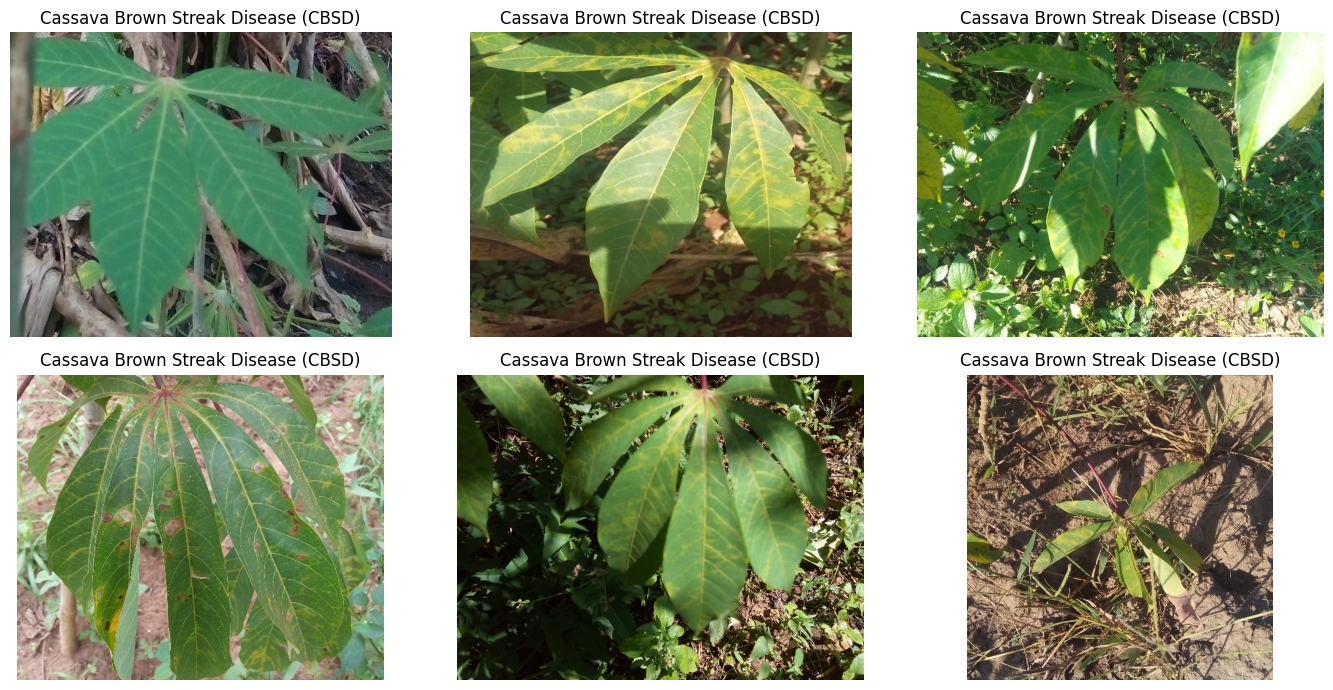

In [73]:
plot_images(data_paths['train'], label="cbsd")

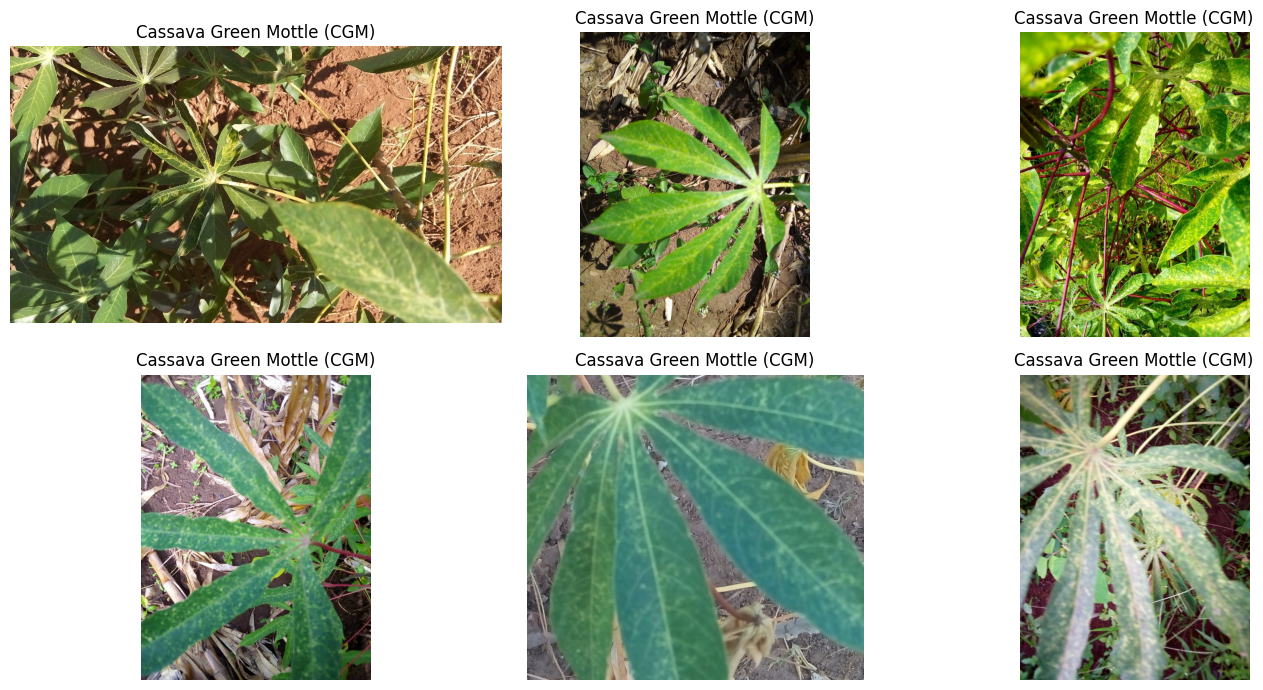

In [74]:
plot_images(data_paths['train'], label="cgm")

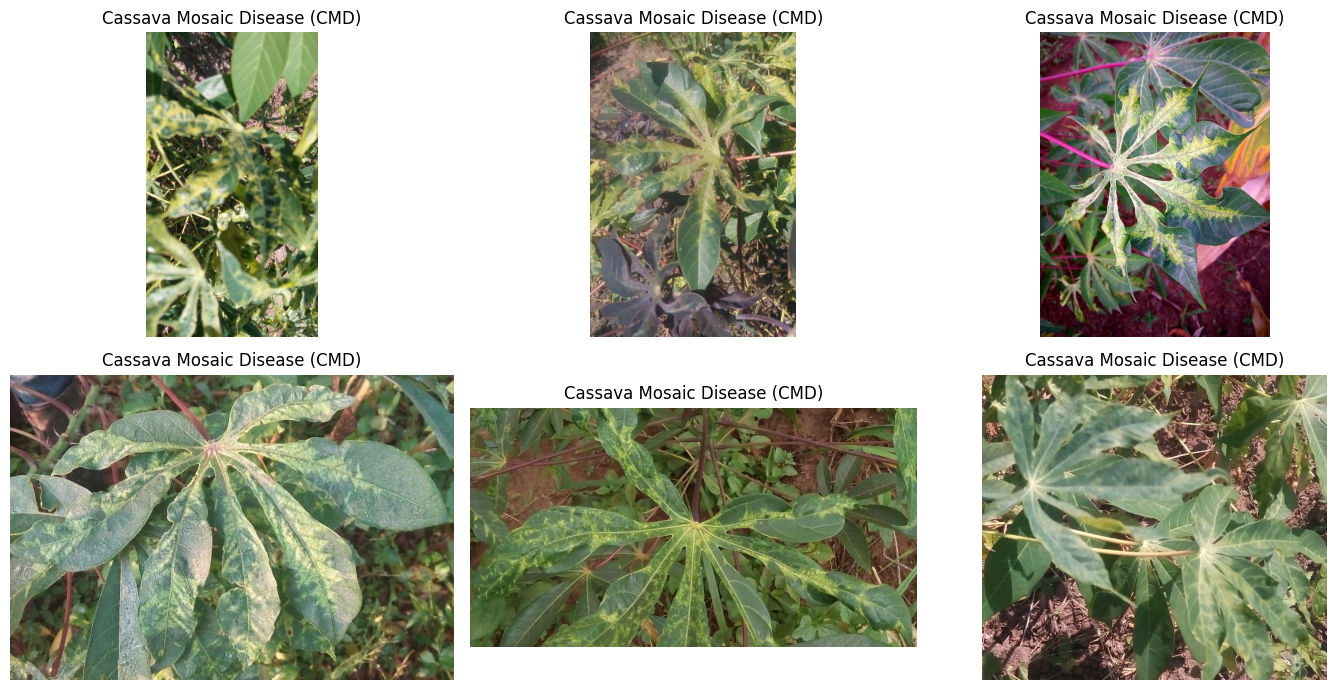

In [75]:
plot_images(data_paths['train'], label="cmd")

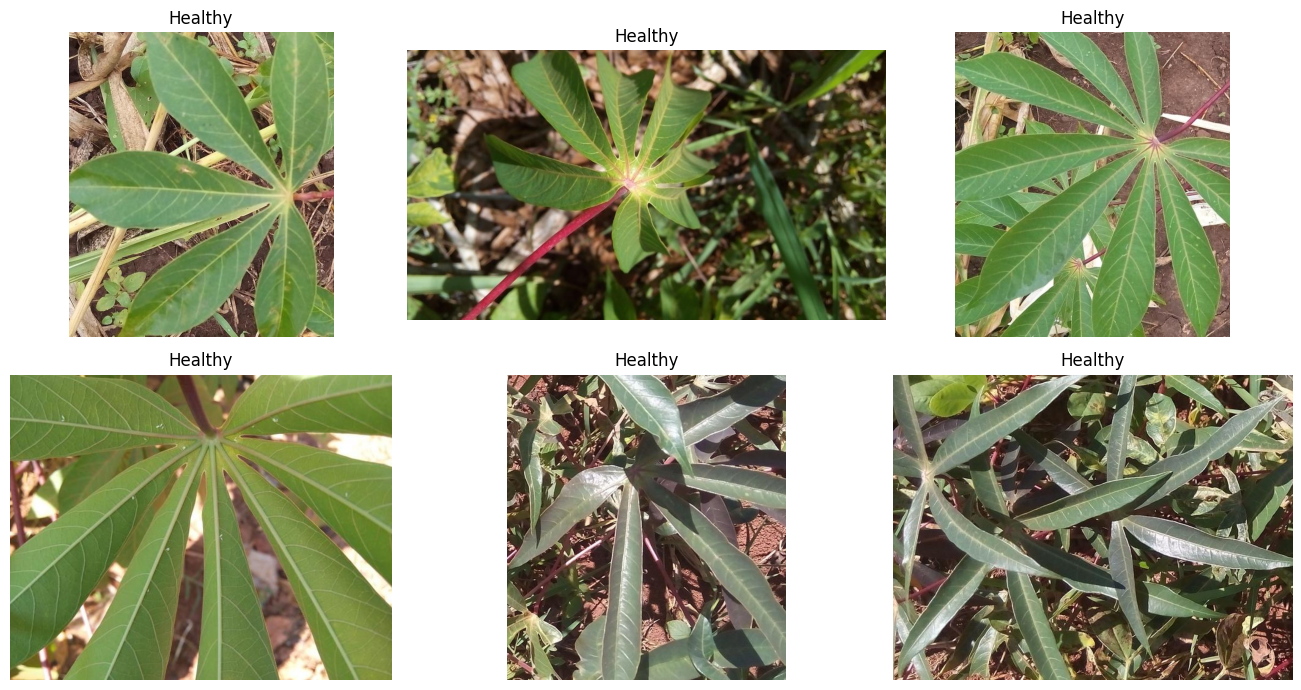

In [76]:
plot_images(data_paths['train'], label="healthy")

####**Preprocessing**

In [77]:
# load image from path
def loader(path):
    return Image.open(path)

In [78]:
img_size = 150

train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

In [79]:
train_data = datasets.ImageFolder(
    root=data_paths['train'],
    loader=loader,
    transform=train_transforms
)
valid_data = datasets.ImageFolder(
    root=data_paths['valid'],
    transform=train_transforms
)
test_data = datasets.ImageFolder(
    root=data_paths['test'],
    transform=train_transforms
)

####**Dataloader**

In [80]:
BATCH_SIZE = 512

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)
valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

In [81]:
len(train_dataloader)

12

In [82]:
inputs, labels = next(iter(train_dataloader))

In [84]:
inputs.shape, labels.shape

(torch.Size([512, 3, 150, 150]), torch.Size([512]))

####**Model**

In [89]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
      super(LeNetClassifier, self).__init__()
      self.conv1 = nn.Conv2d(
          in_channels=3, out_channels=6, kernel_size=5, padding='same'
      )
      self.avgpool1 = nn.AvgPool2d(kernel_size=2)
      self.conv2 = nn.Conv2d(
          in_channels=6, out_channels=16, kernel_size=5
      )
      self.avgpool2 = nn.AvgPool2d(kernel_size=2)
      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(in_features=16*35*35, out_features=120)
      self.fc2 = nn.Linear(in_features=120, out_features=84)
      self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, inputs):
      x = self.conv1(inputs)
      x = self.avgpool1(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = self.avgpool2(x)
      x = F.relu(x)
      x = self.flatten(x)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      x = F.relu(x)
      x = self.fc3(x)
      return x

In [90]:
num_classes = len(train_data.classes)
num_classes

5

In [93]:
lenet_model = LeNetClassifier(num_classes).to(device)

In [94]:
summary(lenet_model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 150, 150]             456
         AvgPool2d-2            [-1, 6, 75, 75]               0
            Conv2d-3           [-1, 16, 71, 71]           2,416
         AvgPool2d-4           [-1, 16, 35, 35]               0
           Flatten-5                [-1, 19600]               0
            Linear-6                  [-1, 120]       2,352,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                    [-1, 5]             425
Total params: 2,365,581
Trainable params: 2,365,581
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 2.20
Params size (MB): 9.02
Estimated Total Size (MB): 11.48
----------------------------------------------------------------


In [97]:
predictions = lenet_model(inputs.to(device))

In [98]:
predictions

tensor([[-0.0571,  0.1054, -0.0522,  0.0897, -0.0960],
        [-0.0479,  0.1073, -0.0538,  0.0812, -0.0921],
        [-0.0370,  0.1063, -0.0636,  0.0786, -0.0898],
        ...,
        [-0.0448,  0.1078, -0.0560,  0.0792, -0.0883],
        [-0.0612,  0.1169, -0.0428,  0.0837, -0.0909],
        [-0.0503,  0.1145, -0.0568,  0.0909, -0.0921]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

####**Loss & Optimizer**

In [104]:
optimizer = optim.Adam(lenet_model.parameters())

In [105]:
criterion = nn.CrossEntropyLoss()

In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [107]:
lenet_model.to(device)

LeNetClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=19600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

####**Trainer**

In [109]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=15):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.5f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [110]:
train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device)

In [112]:
train_acc, train_loss

(0.4542079207920792, 1.3762339850266774)

In [113]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [114]:
eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)

In [115]:
eval_acc, eval_loss

(0.4695606140815246, 1.358488067984581)

####**Training**

In [120]:
num_classes = len(train_data.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 2e-4
optimizer = optim.Adam(lenet_model.parameters(), learning_rate)

num_epochs = 30
save_model = './models'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch, log_interval=10)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        os.makedirs(save_model, exist_ok=True)
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model_for_cassavaleaf.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.5f} | Train Loss {:8.5f} "
        "| Valid Accuracy {:8.5f} | Valid Loss {:8.5f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    lenet_model.load_state_dict(torch.load(save_model + '/lenet_model_for_cassavaleaf.pt', weights_only=True))
    lenet_model.eval()

| epoch   1 |    10/   12 batches | accuracy  0.44371
-----------------------------------------------------------
| End of epoch   1 | Time: 48.17s | Train Accuracy  0.45833 | Train Loss  1.45249 | Valid Accuracy  0.46956 | Valid Loss  1.39266 
-----------------------------------------------------------
| epoch   2 |    10/   12 batches | accuracy  0.46964
-----------------------------------------------------------
| End of epoch   2 | Time: 47.17s | Train Accuracy  0.54167 | Train Loss  1.35804 | Valid Accuracy  0.46956 | Valid Loss  1.35060 
-----------------------------------------------------------
| epoch   3 |    10/   12 batches | accuracy  0.47053
-----------------------------------------------------------
| End of epoch   3 | Time: 47.19s | Train Accuracy  0.33333 | Train Loss  1.35663 | Valid Accuracy  0.46956 | Valid Loss  1.34098 
-----------------------------------------------------------
| epoch   4 |    10/   12 batches | accuracy  0.46999
-------------------------------

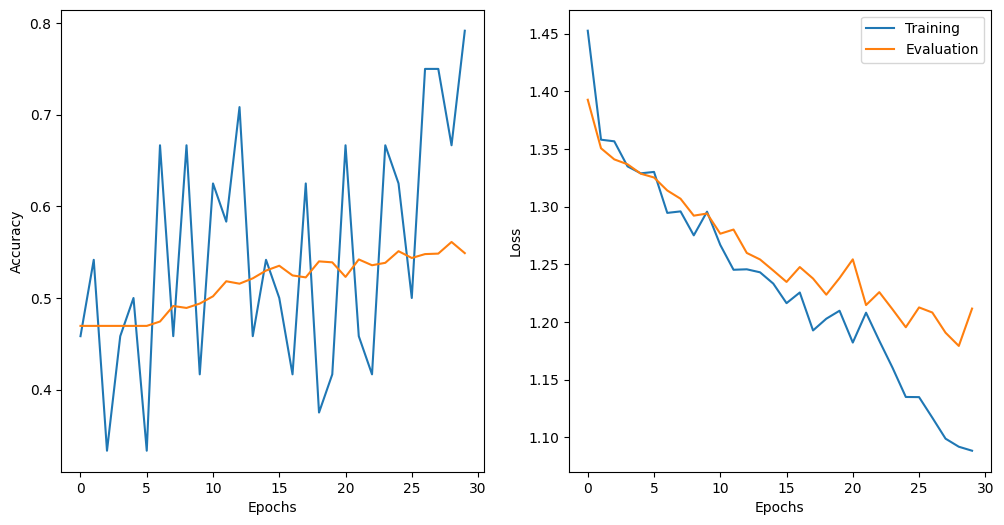

In [125]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

####**Evaluation & Prediction**

In [126]:
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device)
test_acc, test_loss

(0.5639257294429708, 1.1746342480182648)

####**Inference**

In [127]:
def load_model(model_path, num_classes=5):
    lenet_model = LeNetClassifier(num_classes)
    lenet_model.load_state_dict(torch.load(model_path, weights_only=True))
    lenet_model.eval()
    return lenet_model

def inference(img_path, model):
    image = Image.open(img_path)
    img_size = 150

    img_transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ])
    img_new = img_transform(image)
    img_new = torch.unsqueeze(img_new, 0)
    with torch.no_grad():
        predictions = model(img_new)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return p_max.item(), yhat.item()

In [128]:
model = load_model('/content/cassavaleafdata/models/lenet_model_for_cassavaleaf.pt')
preds = inference('/content/cassavaleafdata/test/cbb/test-cbb-10.jpg', model)
preds

(0.3236161768436432, 3)

In [129]:
train_data.class_to_idx

{'cbb': 0, 'cbsd': 1, 'cgm': 2, 'cmd': 3, 'healthy': 4}

In [130]:
idx2label = {
  0: 'cbb',
  1: 'cbsd',
  2: 'cgm',
  3: 'cmd',
  4: 'healthy',
}

In [131]:
idx2label[4]

'healthy'

##**CNN for Text Classification**

###**Load dataset**

In [7]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
y
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (39/39), 186.94 MiB | 1023.00 KiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

In [9]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [10]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

###**Preprocessing**

In [ ]:
!pip install langid

In [12]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [13]:
train_df_vi, train_df_other = identify_vn(train_df)

In [14]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [15]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

<ipython-input-15-e21d2b59a2cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]


In [16]:
train_df_vi

sentence  label  \
0      < a class = ' hashtag-link ' href = ' / ho-chi...      0   
1      Đồ_ăn ở đây ướp thấm vs giá_cả fai chăng thik ...      0   
2      Chỗ này giờ là cửa_hàng bánh rồi .\n Thay tên ...      0   
3      Khá bất_ngờ là phần nước của quán là của start...      0   
4      Thái_độ nhân_viên cực_kì tệ như mình ăn thiếu ...      0   
...                                                  ...    ...   
29995  Mình đến đây được vài lần thấy spa có không_gi...      1   
29996  Xu ́ c xi ́ ch lô ́ c xoa ́ y chiên xu ̀ thơm ...      1   
29997  Ở gần quán đã ghé ăn nhiều lần , càng ăn càng ...      1   
29998  Bánh bông lan trứng muối rất ngon . Đồ uống vừ...      1   
29999  Món kem khá ổn , giá_cả bình_dân , hợp túi_tiề...      1   

                                     preprocess_sentence  
0      smoothies fresh ngoài ra thì bình thuong đi đô...  
1      đồ ăn ở đây ướp thấm vs giá cả fai chăng thik ...  
2      chỗ này giờ là cửa hàng bánh rồi thay tên đổi ...  
3      khá bất ngờ là phần nước của quán là của start...  
4      thái độ nhân viên cực kì tệ như mình ăn thiếu ...  
...                                                  ...  
29995  mình đến đây được vài lần thấy spa có không gi...  
29996  xu ́ c xi ́ ch lô ́ c xoa ́ y chiên xu ̀ thơm ...  
29997  ở gần quán đã ghé ăn nhiều lần càng ăn càng th...  
29998  bánh bông lan trứng muối rất ngon đồ uống vừa ...  
29999  món kem khá ổn giá cả bình dân hợp túi tiền si...  

[29736 rows x 3 columns]

###**Representation**

In [ ]:
!pip install torchtext==0.16.0

In [19]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [20]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [21]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [22]:
vocabulary["<pad>"]

0

In [23]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

###**Dataloader**

In [43]:
import torch
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value=vocabulary["<pad>"]
    )

    return encoded_sentences, labels

In [44]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [45]:
next(iter(train_dataloader))

(tensor([[342,   4,  13,  ..., 109, 298,   3],
         [356, 643,  58,  ..., 498, 493,   9],
         [241,  18,   6,  ..., 254, 272,  34],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]),
 tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
         1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
         0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
         1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
         1, 0, 1, 0, 0, 1, 1, 0]))

In [46]:
encoded_sentences, labels = next(iter(train_dataloader))

In [47]:
encoded_sentences.shape, labels.shape

(torch.Size([580, 128]), torch.Size([128]))

###**Model**
https://arxiv.org/pdf/1408.5882

In [49]:
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
        super(TextCNN, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes

        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.embedding_dim
        )

        self.convolutions = nn.ModuleList([
            nn.Conv1d(
                in_channels=self.embedding_dim,
                out_channels=self.num_filters,
                kernel_size=kernel_size
            ) for kernel_size in self.kernel_sizes
        ])

        self.fully_connected = nn.Linear(
            in_features=self.num_filters * len(self.kernel_sizes),
            out_features=self.num_classes
        )



    def forward(self, x):
      batch_size, seq_len = x.shape
      x = self.embedding(x.T)
      x = x.permute(0, 2, 1)
      x = [F.relu(conv(x)) for conv in self.convolutions]
      x = [F.max_pool1d(x_conv, x_conv.shape[2]).squeeze(dim=-1) for x_conv in x]
      x = torch.cat(x, dim=1)
      x = self.fully_connected(x)
      return x

In [50]:
vocab_size = len(vocabulary)
embedding_dim = 100

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)

In [51]:
vocab_size

10000

In [52]:
predictions = model(encoded_sentences)
predictions

tensor([[-0.9396,  1.0179],
        [-0.9530,  1.1626],
        [-0.9585,  0.4627],
        [-1.0735,  1.0204],
        [-0.8147,  0.8594],
        [-0.7263,  0.6934],
        [-0.5282,  0.7513],
        [-0.9036,  1.1916],
        [-0.8600,  0.7792],
        [-0.6716,  1.0477],
        [-1.1310,  1.0516],
        [-0.8296,  0.6668],
        [-0.7269,  0.7312],
        [-0.4510,  0.8606],
        [-0.8134,  1.0758],
        [-0.5046,  0.7556],
        [-0.6358,  0.7777],
        [-0.9014,  0.6616],
        [-0.6546,  0.8058],
        [-0.9646,  0.9351],
        [-0.9603,  0.9556],
        [-1.0942,  0.6355],
        [-0.7379,  1.3069],
        [-0.6089,  0.7760],
        [-0.6663,  1.2631],
        [-0.6125,  0.6932],
        [-0.5297,  0.6745],
        [-1.1252,  0.6485],
        [-0.3967,  0.6146],
        [-0.8604,  0.9667],
        [-0.6589,  1.0897],
        [-0.8507,  0.8256],
        [-0.9036,  0.8689],
        [-0.8590,  0.7987],
        [-1.0981,  0.7696],
        [-1.0906,  0

In [53]:
predictions.shape

torch.Size([128, 2])

###**Loss & Optimizer**

In [54]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [55]:
loss = criterion(predictions, labels)
loss

tensor(1.0367, grad_fn=<NllLossBackward0>)

###**Trainer**

In [56]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero grad
        optimizer.zero_grad()

        # predictions
        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [57]:
model.to(device)

TextCNN(
  (embedding): Embedding(10000, 100)
  (convolutions): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fully_connected): Linear(in_features=300, out_features=2, bias=True)
)

In [58]:
epoch_acc, epoch_loss = train(model, optimizer, criterion, train_dataloader, device)

| epoch   0 |    50/  233 batches | accuracy    0.736
| epoch   0 |   100/  233 batches | accuracy    0.846
| epoch   0 |   150/  233 batches | accuracy    0.866
| epoch   0 |   200/  233 batches | accuracy    0.873


In [59]:
epoch_acc, epoch_loss

(0.8667664670658682, 0.3839388588211567)

In [60]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # predictions
            predictions = model(inputs)

            # compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [61]:
eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)

In [62]:
eval_acc, eval_loss

(0.8746, 0.3103251472304139)

###**Training**

In [65]:
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 10
save_model = './models'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + '/text_cnn_model.pt'))
    model.eval()

| epoch   1 |    50/  233 batches | accuracy    0.725
| epoch   1 |   100/  233 batches | accuracy    0.852
| epoch   1 |   150/  233 batches | accuracy    0.871
| epoch   1 |   200/  233 batches | accuracy    0.868
-----------------------------------------------------------
| End of epoch   1 | Time:  9.25s | Train Accuracy    0.882 | Train Loss    0.381 | Valid Accuracy    0.874 | Valid Loss    0.307 
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.921
| epoch   2 |   100/  233 batches | accuracy    0.913
| epoch   2 |   150/  233 batches | accuracy    0.915
| epoch   2 |   200/  233 batches | accuracy    0.909
-----------------------------------------------------------
| End of epoch   2 | Time:  9.10s | Train Accuracy    0.903 | Train Loss    0.231 | Valid Accuracy    0.846 | Valid Loss    0.348 
-----------------------------------------------------------
| epoch   3 |    50/  233 batches | accuracy    0.958
| epoch   3 

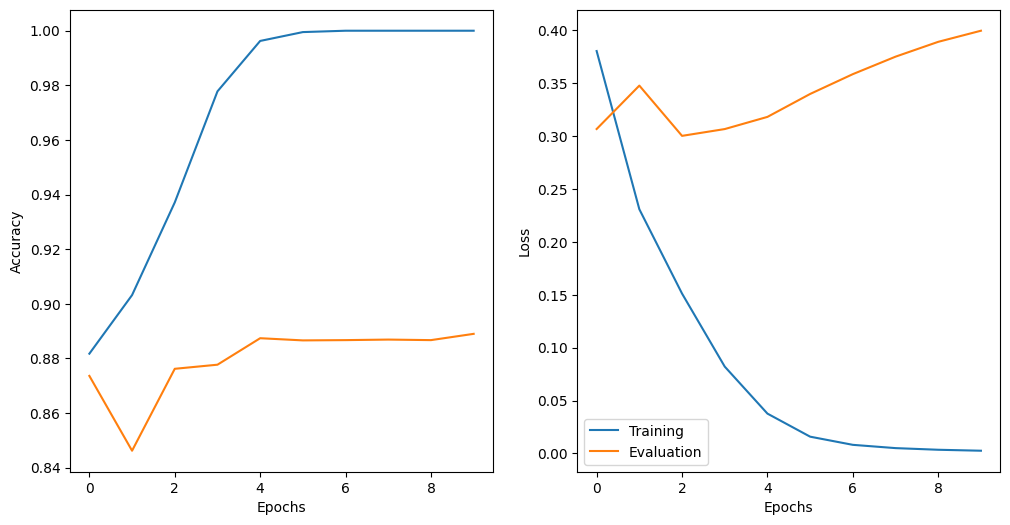

In [68]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

###**Evaluation & Prediction**

In [69]:
test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [70]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [71]:
test_acc, test_loss = evaluate(model, criterion, valid_dataloader, device)
test_acc, test_loss

(0.889, 0.39972800072989884)

###**Inference**

In [72]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

def load_model(model_path, vocab_size=10000, embedding_dim=100, num_classes=2):
    model = TextCNN(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        kernel_sizes=[3, 4, 5],
        num_filters=100,
        num_classes=num_classes
    )
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

def inference(sentence, vocabulary, model):
    encoded_sentence = vocabulary(tokenizer(sentence))
    encoded_sentence = torch.tensor(encoded_sentence)
    encoded_sentence = torch.unsqueeze(encoded_sentence, 1)

    with torch.no_grad():
        predictions = model(encoded_sentence)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return round(p_max.item(), 2)*100, yhat.item()

In [73]:
model = load_model('./models/text_cnn_model.pt')
inference(test_df['preprocess_sentence'][0], vocabulary, model)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


(100.0, 0)

In [74]:
# save vocabulary as pth

torch.save(vocabulary, './models/vocabulary.pth')



In [75]:
vocabulary2 = torch.load('./models/vocabulary.pth')
model = load_model('./models/text_cnn_model.pt')
inference(test_df['preprocess_sentence'][0], vocabulary, model)

(100.0, 0)